# Step 1. 실험환경 Set-up

In [21]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16 # 20으로 변경했을 때 accuracy(72%)
EPOCHS = 16 # 학습해본 결과, 25 → 20 → 16  으로 accuracy를 높이기 위해 변경(시각화 결과 적정 epoch라고 판단)

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [44]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [45]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" 

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [46]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [47]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## augmentation
#### - 이미지 학습 때, 학습 셋을 다양한 증강방식을 사용하여 최대한 확보함으로써 over-fitting을 방지할 수 있다.
#### - 픽셀 표준화, zca whitening, random transformation, color noise 등이 있는데    여기선 좌우 반전 이미지를 사용

In [48]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

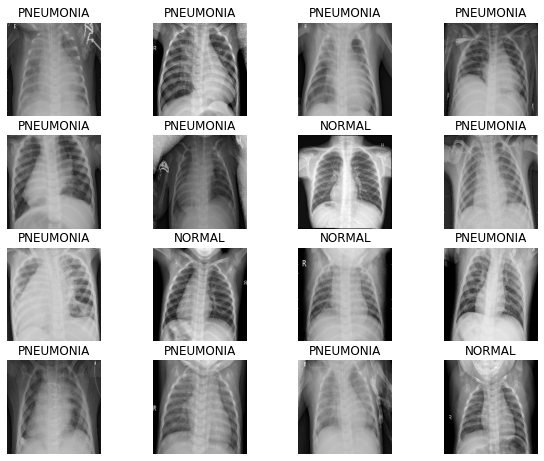

In [49]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [50]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), # BN을 쓰지 않을경우, accuracy가 훨씬 낮아진다.
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [51]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [52]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

#### -  메디컬 이미지의 경우 Normal Data는 수없이 많지만 Abnormal Data가 대단히 부족한 상황이 대다수

#### - 다른 클래스는 제쳐두고 정상인 케이스 하나만큼은 제대로 분류하려는 경향을 띄게 되고 이에 질병에 대한 민감도(Sensitivity)가 줄어든다.

#### - recall(재현율) : 실제로 정답이 True 인 것들 중에서 분류기가 True로 예측한 비율
#### - 의료현장에서는 recall을 높이는 것이 중요한데 weight를 조정하는 방법이 그 중 하나의 방법

In [53]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Normal images count in training set: 1056
Pneumonia images count in training set: 3129
Training images count: 4185
Validating images count: 1047
Weight for NORMAL: 1.98
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [54]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/16
261/261 [==============================] - 60s 137ms/step - loss: 0.5546 - accuracy: 0.7125 - precision: 0.9166 - recall: 0.6777 - val_loss: 0.6450 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 1.0000
Epoch 2/16
261/261 [==============================] - 35s 133ms/step - loss: 0.2543 - accuracy: 0.8969 - precision: 0.9706 - recall: 0.8894 - val_loss: 1.3309 - val_accuracy: 0.7202 - val_precision: 0.7202 - val_recall: 1.0000
Epoch 3/16
261/261 [==============================] - 35s 133ms/step - loss: 0.2032 - accuracy: 0.9187 - precision: 0.9784 - recall: 0.9110 - val_loss: 0.2392 - val_accuracy: 0.8808 - val_precision: 0.8581 - val_recall: 1.0000
Epoch 4/16
261/261 [==============================] - 35s 133ms/step - loss: 0.1748 - accuracy: 0.9369 - precision: 0.9736 - recall: 0.9416 - val_loss: 0.1272 - val_accuracy: 0.9510 - val_precision: 0.9929 - val_recall: 0.9386
Epoch 5/16
261/261 [==============================] - 35s 133ms/step - loss: 0.1846 - accura

# Step 7. 결과 확인과 시각화
#### - accuracy를 높이기 위해 epoch를 조정할 때, recall이 1에서 0.98로 낮아졌다.

In [55]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.5008 - accuracy: 0.8494 - precision: 0.8136 - recall: 0.9846
Loss: 0.5007529854774475,
Accuracy: 0.8493589758872986,
Precision: 0.8135592937469482,
Recall: 0.9846153855323792


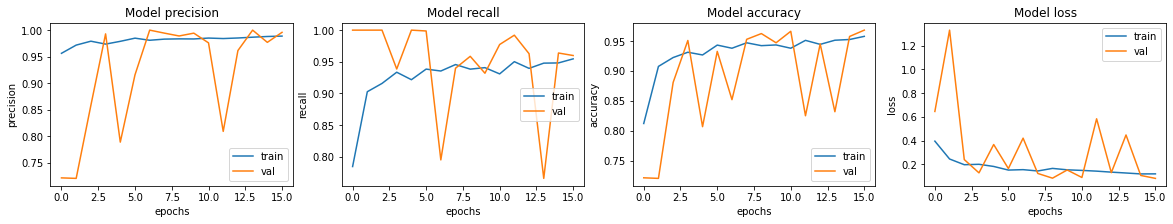

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])